In [5]:
import os

# Configurar SPARK_HOME
os.environ['SPARK_HOME'] = '/opt/spark'

# Agregar SPARK_HOME al PATH
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['SPARK_HOME'], 'bin')

# Verificar si Spark está en el PATH
!echo $PATH


/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin:/opt/spark/bin:/opt/spark/bin:/opt/spark/bin


In [2]:
# Importar SparkSession
from pyspark.sql import SparkSession

In [13]:
import pandas as pd
from pyspark.sql import SparkSession
from dbfread import DBF

# Paso 1: Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("Proyecto de análisis de transporte") \
    .getOrCreate()

# Paso 2: Especificar la ruta al archivo DBF
archivo_dbf = "taxi_zones.dbf"

# Paso 3: Leer el archivo DBF utilizando dbfread
with DBF(archivo_dbf) as dbf:
    df_dbf_pandas = pd.DataFrame(iter(dbf))


In [14]:
df_dbf_pandas

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,1,0.116357,0.000782,Newark Airport,1,EWR
1,2,0.433470,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,0.000498,Arden Heights,5,Staten Island
...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx
259,260,0.133514,0.000422,Woodside,260,Queens
260,261,0.027120,0.000034,World Trade Center,261,Manhattan
261,262,0.049064,0.000122,Yorkville East,262,Manhattan


In [107]:
df_spark = spark.createDataFrame(df_dbf_pandas)

In [109]:
df_spark.show()

+--------+---------------+----------------+--------------------+----------+-------------+
|OBJECTID|     Shape_Leng|      Shape_Area|                zone|LocationID|      borough|
+--------+---------------+----------------+--------------------+----------+-------------+
|       1| 0.116357453189|  7.823067885E-4|      Newark Airport|         1|          EWR|
|       2|  0.43346966679|0.00486634037837|         Jamaica Bay|         2|       Queens|
|       3|0.0843411059012|3.14414156821E-4|Allerton/Pelham G...|         3|        Bronx|
|       4|0.0435665270921|1.11871946192E-4|       Alphabet City|         4|    Manhattan|
|       5|0.0921464898574|4.97957489363E-4|       Arden Heights|         5|Staten Island|
|       6| 0.150490542523|6.06460984581E-4|Arrochar/Fort Wad...|         6|Staten Island|
|       7| 0.107417171123|3.89787989274E-4|             Astoria|         7|       Queens|
|       8|0.0275906911574| 2.6587716279E-5|        Astoria Park|         8|       Queens|
|       9|

In [110]:
# Calcular el flujo máximo por zona
flow_by_zone = df_spark.groupBy('zone').agg({'Shape_Area': 'max'}).withColumnRenamed('max(Shape_Area)', 'max_flow')

In [114]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
import seaborn as sns
import matplotlib.pyplot as plt
# Ordenar los resultados por el flujo máximo en orden descendente
flow_by_zone_sorted = flow_by_zone.orderBy(desc('max_flow'))

In [115]:
# Mostrar solo algunas de las zonas con el flujo máximo
top_zones = flow_by_zone_sorted.limit(5)
top_zones.show()

+--------------------+----------------+
|                zone|        max_flow|
+--------------------+----------------+
|         Jamaica Bay|0.00486634037837|
|Bloomfield/Emerso...|0.00219556576201|
|Eltingville/Annad...|0.00207375572052|
|         JFK Airport|0.00203830095472|
|Schuylerville/Edg...|0.00202032598969|
+--------------------+----------------+



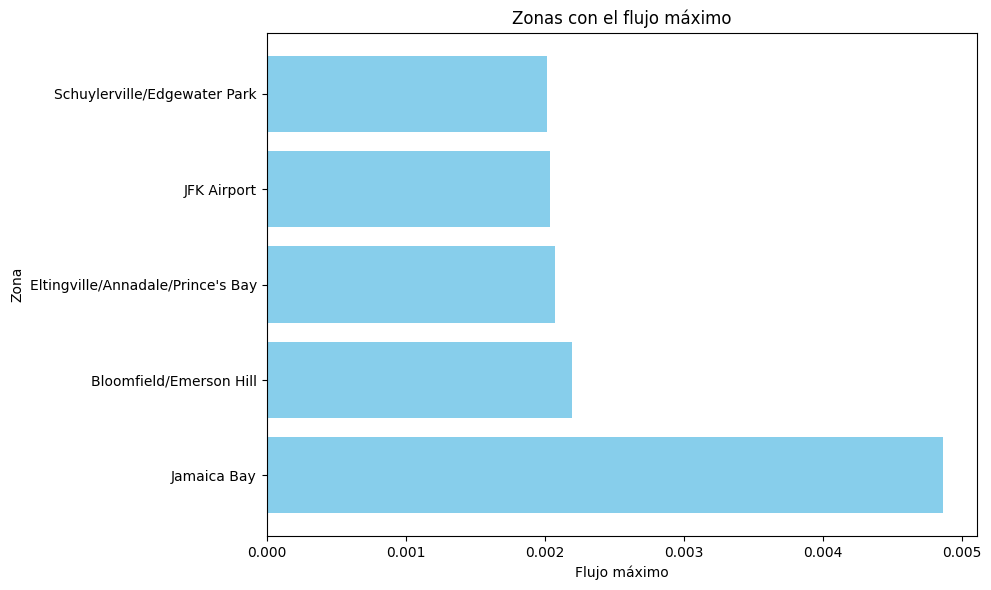

In [116]:
# Convertir el DataFrame de PySpark a un DataFrame de Pandas para la visualización
top_zones_pd = top_zones.toPandas()

# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras
plt.barh(top_zones_pd['zone'], top_zones_pd['max_flow'], color='skyblue')

# Añadir etiquetas y título
plt.xlabel('Flujo máximo')
plt.ylabel('Zona')
plt.title('Zonas con el flujo máximo')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [118]:
# Describir el DataFrame top_zones
top_zones.describe().show()

+-------+--------------------+--------------------+
|summary|                zone|            max_flow|
+-------+--------------------+--------------------+
|  count|                   5|                   5|
|   mean|                NULL|0.002638857761061...|
| stddev|                NULL|0.001247074271334...|
|    min|Bloomfield/Emerso...|    0.00202032598969|
|    max|Schuylerville/Edg...|    0.00486634037837|
+-------+--------------------+--------------------+



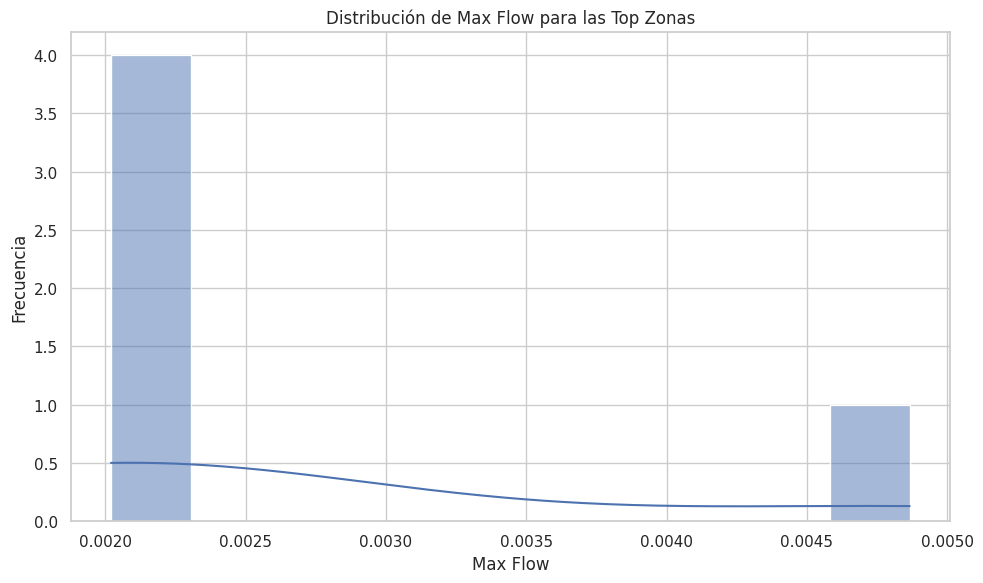

In [120]:
# Importar Seaborn para la visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el gráfico de distribución de max_flow
plt.figure(figsize=(10, 6))
sns.histplot(data=top_zones_pd, x='max_flow', bins=10, kde=True)
plt.title('Distribución de Max Flow para las Top Zonas')
plt.xlabel('Max Flow')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()



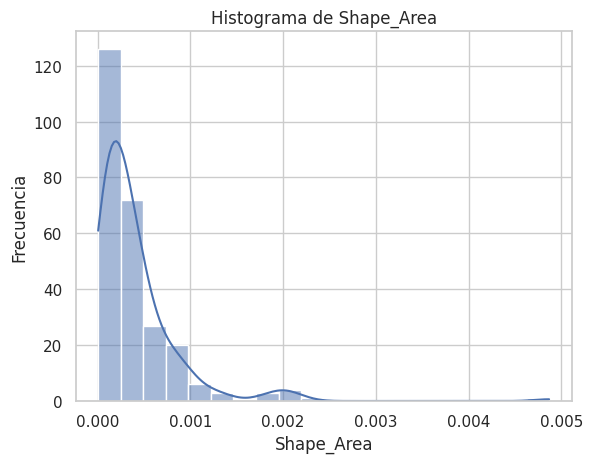

In [123]:
# Histograma de una columna específica (por ejemplo, Shape_Area)
column_data = df_spark.select('Shape_Area').toPandas()
sns.histplot(column_data['Shape_Area'], bins=20, kde=True)
plt.title('Histograma de Shape_Area')
plt.xlabel('Shape_Area')
plt.ylabel('Frecuencia')
plt.show()


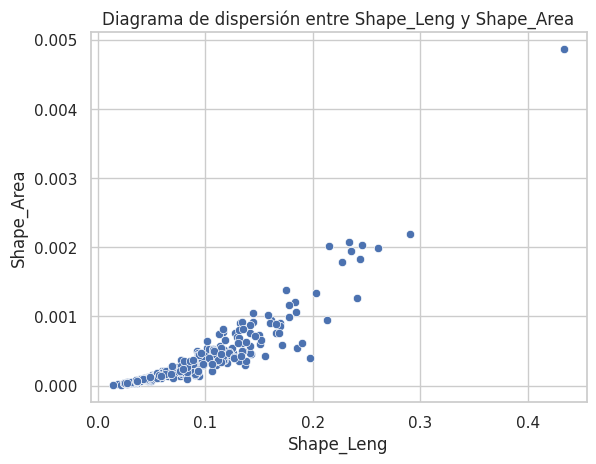

In [125]:
# Visualización adicional (por ejemplo, diagrama de dispersión entre Shape_Leng y Shape_Area)
sns.scatterplot(x='Shape_Leng', y='Shape_Area', data=df_spark.toPandas())
plt.title('Diagrama de dispersión entre Shape_Leng y Shape_Area')
plt.xlabel('Shape_Leng')
plt.ylabel('Shape_Area')
plt.show()
